# **Meme Kanserinde Yapay Zeka Tabanlı Tümör Sınıflandırması**

 **Verimi " https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data " adresinden aldım**
 
Bu veri seti, göğüs kanseri teşhisinde kullanılan ölçümleri içerir ve kanser türlerini iyi huylu (benign) ve kötü huylu (malignant) olarak sınıflandırmayı hedefler. 

Amacım ise göğüs kanseri gibi ciddi bir hastalığın teşhisinde destek sağlamak ve makine öğrenimi modellerinin bu alandaki potansiyelini göstermek için nu konuyu seçtim
 

In [408]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pandas as pd
import numpy as np

In [289]:
# verilerimizi datnımlayarak data değişkeninin içine attık
data = pd.read_csv("data.csv")

In [290]:
# veri hakkında genel bilgi aldım türü veri türleri gibi
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [291]:
# ilk 5 elemanın değerlerini görüntüledim
print(data.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [292]:
# veri türlerinin değerlerini ve bu değerlerin dağılım gözlemlendi
print(data.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

In [293]:
# anlamsız yada işime yaramayacak değerleri çıkarttım
data.drop(["Unnamed: 32", "id"], axis=1, inplace=True, errors='ignore')


In [294]:
# Verilerin silindiğinden emin olup görüntüledim
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

**Genel anlamda çıkarımlarım şu şekilde :**

'id' sütunu, veri setinde sadece tanımlayıcı özelliğilduğu için ve herhangi bir işime yaramayacağı için veri setinden çıkaracağım.
'Unnamed: 32' sütunu tamamen boş ve veri setinden çıkarılmalı.
'diagnosis' sütunu hedef değişken olarak görünüyor. Sütun, tanı türünü ('M' ve 'B' gibi sınıflar) içeriyor.

In [296]:
# silme işlemi ile birlikte verimde sayısayl olmayan tek veri türü diagnosis (yani teşhis) veri türüdür ve bende bu veriyi sayısal veri türüne çevirdim
# burada M (Malignant) yani kötü hüylü tümör varsa 1 , B (Benign) yani iyi huylu tümör varsa 0 dönecek şekilde ayarlayarak verimi sayısal hale getirdim
data.diagnosis = [1 if each == "M" else 0 for each in data.diagnosis]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

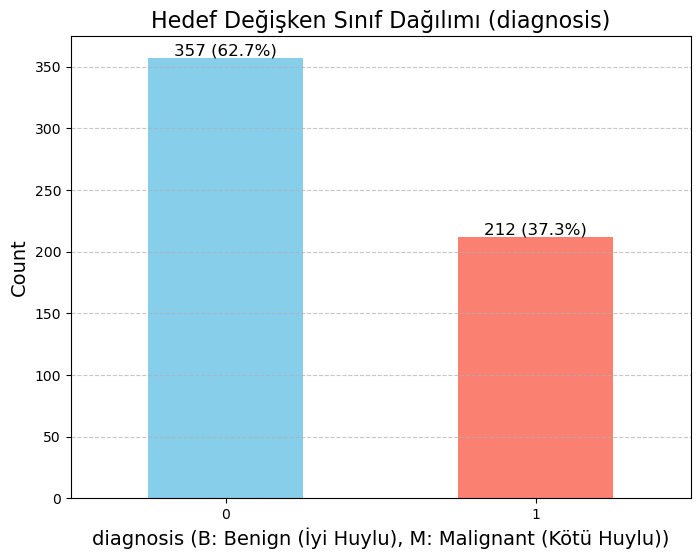

In [297]:
class_distribution = data['diagnosis'].value_counts()
total_count = class_distribution.sum()

# Çubuk grafiği oluşturma
plt.figure(figsize=(8, 6))
bars = class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])  # Renkler sınıf sayısıyla uyumlu olmalı
plt.title('Hedef Değişken Sınıf Dağılımı (diagnosis)', fontsize=16)
plt.xlabel('diagnosis (B: Benign (İyi Huylu), M: Malignant (Kötü Huylu))', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Alt kısma adet ve oran bilgisi ekleme
for i, value in enumerate(class_distribution):
    percentage = (value / total_count) * 100
    plt.text(i, value + 2, f"{value} ({percentage:.1f}%)", ha='center', fontsize=12, color='black')

plt.show()

## *2. Veri Ön İşleme (Preprocessing)*

In [299]:
# Hedef ve Özelliklerin Ayırılması
y = data.diagnosis.values
x_data = data.drop(["diagnosis"],axis=1)

In [300]:
# normalizasyon yaparak tüm özelliklerin aynı ölçeğe getirilmesini sağladım.
X_normalized_df = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [301]:
print(X_normalized_df.head())

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     0.004229      0.002440        0.028867   0.235308         0.000028   
1     0.004835      0.004177        0.031241   0.311707         0.000020   
2     0.004629      0.004995        0.030559   0.282793         0.000026   
3     0.002685      0.004791        0.018237   0.090762         0.000033   
4     0.004770      0.003371        0.031758   0.304890         0.000024   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          0.000065        0.000071             0.000035       0.000057   
1          0.000018        0.000020             0.000016       0.000043   
2          0.000038        0.000046             0.000030       0.000049   
3          0.000067        0.000057             0.000025       0.000061   
4          0.000031        0.000047             0.000025       0.000043   

   fractal_dimension_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0           

In [302]:
# Feature Engineering: Yeni Özelliklerin Eklenmesi
X_normalized_df["perimeter_to_radius_ratio"] = X_normalized_df["perimeter_mean"] / X_normalized_df["radius_mean"]
X_normalized_df["area_to_perimeter_ratio"] = X_normalized_df["area_mean"] / X_normalized_df["perimeter_mean"]
X_normalized_df["compactness_concavity_product"] = X_normalized_df["compactness_mean"] * X_normalized_df["concavity_mean"]

# Normalize Yeni Özellikler
for feature in ["perimeter_to_radius_ratio", "area_to_perimeter_ratio", "compactness_concavity_product"]:
    X_normalized_df[feature] = (X_normalized_df[feature] - X_normalized_df[feature].min()) / (
        X_normalized_df[feature].max() - X_normalized_df[feature].min()
    )

# Korelasyon Analizi
correlation_with_target = X_normalized_df.copy()
correlation_with_target["diagnosis"] = y  # Hedef değişkeni ekleyelim

# Korelasyon hesaplama
correlation_matrix = correlation_with_target.corr()
new_feature_correlations = correlation_matrix["diagnosis"].loc[
    ["perimeter_to_radius_ratio", "area_to_perimeter_ratio", "compactness_concavity_product"]
]

# Yeni özelliklerin korelasyonlarını göster
print("Yeni Özelliklerin Hedef Değişkenle Korelasyonları:")
print(new_feature_correlations)



Yeni Özelliklerin Hedef Değişkenle Korelasyonları:
perimeter_to_radius_ratio        0.654453
area_to_perimeter_ratio          0.715978
compactness_concavity_product    0.585277
Name: diagnosis, dtype: float64


**Yeni Özellikler:**

perimeter_to_radius_ratio: Çevre ve yarıçap oranı.

area_to_perimeter_ratio: Alan ve çevre oranı.

compactness_concavity_product: Kompaktlık ve konkavlık çarpımı

In [304]:
# Display the first few rows of the updated normalized DataFrame with new features
X_normalized_df.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,perimeter_to_radius_ratio,area_to_perimeter_ratio,compactness_concavity_product
0,0.004229,0.002440,0.028867,0.235308,0.000028,0.000065,0.000071,0.000035,0.000057,0.000019,...,0.474612,0.000038,0.000156,0.000167,0.000062,0.000108,0.000028,0.688155,0.482406,0.642494
1,0.004835,0.004177,0.031241,0.311707,0.000020,0.000018,0.000020,0.000016,0.000043,0.000013,...,0.459803,0.000029,0.000044,0.000057,0.000044,0.000065,0.000021,0.302021,0.663114,0.052704
2,0.004629,0.004995,0.030559,0.282793,0.000026,0.000038,0.000046,0.000030,0.000049,0.000014,...,0.401740,0.000034,0.000100,0.000106,0.000057,0.000085,0.000021,0.451622,0.591504,0.243433
3,0.002685,0.004791,0.018237,0.090762,0.000033,0.000067,0.000057,0.000025,0.000061,0.000023,...,0.133451,0.000049,0.000204,0.000161,0.000061,0.000156,0.000041,0.653608,0.168222,0.528550
4,0.004770,0.003371,0.031758,0.304890,0.000024,0.000031,0.000047,0.000025,0.000043,0.000014,...,0.370240,0.000032,0.000048,0.000094,0.000038,0.000056,0.000018,0.510963,0.625791,0.202790


In [305]:
# Türetilmiş ve orijinal özelliklerin korelasyonlarını karşılaştıralım
print("=== Türetilmiş ve Orijinal Özelliklerin Hedef Değişkenle Korelasyonları ===")

# 'perimeter_to_radius_ratio' karşılaştırması
print("\n1. perimeter_to_radius_ratio vs perimeter_mean & radius_mean:")
print(f"  perimeter_to_radius_ratio -> {correlation_with_target['diagnosis'].corr(X_normalized_df['perimeter_to_radius_ratio'])}")
print(f"  perimeter_mean           -> {correlation_with_target['diagnosis'].corr(X_normalized_df['perimeter_mean'])}")
print(f"  radius_mean              -> {correlation_with_target['diagnosis'].corr(X_normalized_df['radius_mean'])}")

# 'area_to_perimeter_ratio' karşılaştırması
print("\n2. area_to_perimeter_ratio vs area_mean & perimeter_mean:")
print(f"  area_to_perimeter_ratio -> {correlation_with_target['diagnosis'].corr(X_normalized_df['area_to_perimeter_ratio'])}")
print(f"  area_mean               -> {correlation_with_target['diagnosis'].corr(X_normalized_df['area_mean'])}")
print(f"  perimeter_mean          -> {correlation_with_target['diagnosis'].corr(X_normalized_df['perimeter_mean'])}")

# 'compactness_concavity_product' karşılaştırması
print("\n3. compactness_concavity_product vs compactness_mean & concavity_mean:")
print(f"  compactness_concavity_product -> {correlation_with_target['diagnosis'].corr(X_normalized_df['compactness_concavity_product'])}")
print(f"  compactness_mean              -> {correlation_with_target['diagnosis'].corr(X_normalized_df['compactness_mean'])}")
print(f"  concavity_mean                -> {correlation_with_target['diagnosis'].corr(X_normalized_df['concavity_mean'])}")


=== Türetilmiş ve Orijinal Özelliklerin Hedef Değişkenle Korelasyonları ===

1. perimeter_to_radius_ratio vs perimeter_mean & radius_mean:
  perimeter_to_radius_ratio -> 0.6544531499727344
  perimeter_mean           -> 0.7426355297258321
  radius_mean              -> 0.7300285113754553

2. area_to_perimeter_ratio vs area_mean & perimeter_mean:
  area_to_perimeter_ratio -> 0.7159776513434111
  area_mean               -> 0.708983836585389
  perimeter_mean          -> 0.7426355297258321

3. compactness_concavity_product vs compactness_mean & concavity_mean:
  compactness_concavity_product -> 0.5852773970246212
  compactness_mean              -> 0.5965336775082525
  concavity_mean                -> 0.6963597071719047


In [306]:
# Türetilmiş özellikleri ve hedef değişkeni korelasyon matrisine ekliyoruz
correlation_with_target = X_normalized_df.copy()
correlation_with_target["diagnosis"] = y  # Hedef değişkeni ekle

# Korelasyon matrisini yeniden hesaplayalım
correlation_matrix = correlation_with_target.corr()

# Türetilmiş ve orijinal özelliklerin seçim süreci
print("=== Türetilmiş ve Orijinal Özelliklerin Seçim Süreci ve Korelasyonları ===")

# 'perimeter_to_radius_ratio' ile 'perimeter_mean' ve 'radius_mean' karşılaştırması
if "perimeter_to_radius_ratio" in correlation_matrix.columns:
    print("\n1. perimeter_to_radius_ratio vs perimeter_mean & radius_mean:")
    print(f"   - perimeter_to_radius_ratio: {correlation_matrix['perimeter_to_radius_ratio']['diagnosis']:.3f}")
    print(f"   - perimeter_mean           : {correlation_matrix['perimeter_mean']['diagnosis']:.3f}")
    print(f"   - radius_mean              : {correlation_matrix['radius_mean']['diagnosis']:.3f}")
    print("   - Karar: Orijinal özellikler ('perimeter_mean' ve 'radius_mean') hedef değişkenle daha güçlü ilişkiye sahip.")
    print("     Bu nedenle 'perimeter_to_radius_ratio' çıkarılıyor.")
    X_normalized_df.drop(columns=["perimeter_to_radius_ratio"], inplace=True)

# 'area_to_perimeter_ratio' ile 'area_mean' ve 'perimeter_mean' karşılaştırması
if "area_to_perimeter_ratio" in correlation_matrix.columns:
    print("\n2. area_to_perimeter_ratio vs area_mean & perimeter_mean:")
    print(f"   - area_to_perimeter_ratio: {correlation_matrix['area_to_perimeter_ratio']['diagnosis']:.3f}")
    print(f"   - area_mean              : {correlation_matrix['area_mean']['diagnosis']:.3f}")
    print(f"   - perimeter_mean         : {correlation_matrix['perimeter_mean']['diagnosis']:.3f}")
    print("   - Karar: 'area_to_perimeter_ratio', hedef değişkenle daha güçlü ilişkiye sahip.")
    print("     Bu nedenle 'area_mean' ve 'perimeter_mean' çıkarılıyor.")
    for col in ["area_mean", "perimeter_mean"]:
        if col in X_normalized_df.columns:
            X_normalized_df.drop(columns=[col], inplace=True)

# 'compactness_concavity_product' ile 'compactness_mean' ve 'concavity_mean' karşılaştırması
if "compactness_concavity_product" in correlation_matrix.columns:
    print("\n3. compactness_concavity_product vs compactness_mean & concavity_mean:")
    print(f"   - compactness_concavity_product: {correlation_matrix['compactness_concavity_product']['diagnosis']:.3f}")
    print(f"   - compactness_mean             : {correlation_matrix['compactness_mean']['diagnosis']:.3f}")
    print(f"   - concavity_mean               : {correlation_matrix['concavity_mean']['diagnosis']:.3f}")
    print("   - Karar: Orijinal özellikler ('compactness_mean' ve 'concavity_mean') hedef değişkenle daha güçlü ilişkiye sahip.")
    print("     Bu nedenle 'compactness_concavity_product' çıkarılıyor.")
    X_normalized_df.drop(columns=["compactness_concavity_product"], inplace=True)

# Kalan özellikleri yazdır
print("\n=== Son Seçimlerden Sonra Kalan Özellikler ===")
print(X_normalized_df.columns)


=== Türetilmiş ve Orijinal Özelliklerin Seçim Süreci ve Korelasyonları ===

1. perimeter_to_radius_ratio vs perimeter_mean & radius_mean:
   - perimeter_to_radius_ratio: 0.654
   - perimeter_mean           : 0.743
   - radius_mean              : 0.730
   - Karar: Orijinal özellikler ('perimeter_mean' ve 'radius_mean') hedef değişkenle daha güçlü ilişkiye sahip.
     Bu nedenle 'perimeter_to_radius_ratio' çıkarılıyor.

2. area_to_perimeter_ratio vs area_mean & perimeter_mean:
   - area_to_perimeter_ratio: 0.716
   - area_mean              : 0.709
   - perimeter_mean         : 0.743
   - Karar: 'area_to_perimeter_ratio', hedef değişkenle daha güçlü ilişkiye sahip.
     Bu nedenle 'area_mean' ve 'perimeter_mean' çıkarılıyor.

3. compactness_concavity_product vs compactness_mean & concavity_mean:
   - compactness_concavity_product: 0.585
   - compactness_mean             : 0.597
   - concavity_mean               : 0.696
   - Karar: Orijinal özellikler ('compactness_mean' ve 'concavity_mean


=== 0.5 Üzeri Korelasyona Sahip Kalan Özellikler ===
diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
area_worst                 0.733825
radius_mean                0.730029
area_to_perimeter_ratio    0.715978
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
Name: diagnosis, dtype: float64


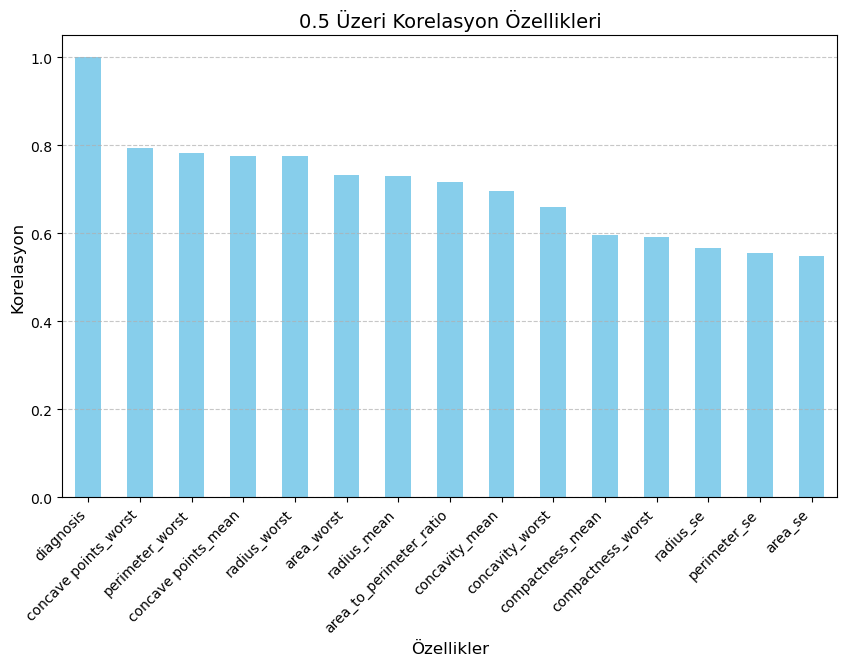

In [307]:
# Kalan özellikleri yeniden belirlemek için korelasyon matrisini X_normalized_df'e göre güncelleyelim
correlation_with_target = X_normalized_df.copy()
correlation_with_target["diagnosis"] = y  # Hedef değişkeni ekle
updated_correlation_matrix = correlation_with_target.corr()

# 0.5 üzeri korelasyona sahip kalan özellikleri seçip sıralayalım
high_correlation_features = updated_correlation_matrix["diagnosis"][updated_correlation_matrix["diagnosis"] > 0.5].sort_values(ascending=False)

# Sonuçları yazdır
print("\n=== 0.5 Üzeri Korelasyona Sahip Kalan Özellikler ===")
print(high_correlation_features)

# 0.5 üzeri korelasyon özelliklerini görselleştir
plt.figure(figsize=(10, 6))
high_correlation_features.plot(kind='bar', color="skyblue")
plt.title("0.5 Üzeri Korelasyon Özellikleri", fontsize=14)
plt.xlabel("Özellikler", fontsize=12)
plt.ylabel("Korelasyon", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()


## Veri Analizi

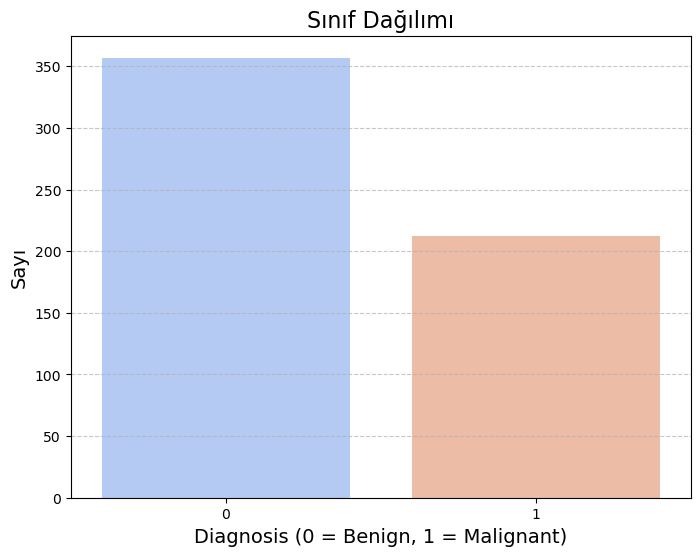


=== Sınıf Dağılımı ===
0    357
1    212
Name: count, dtype: int64

=== Sınıf Oranları ===
0    0.627417
1    0.372583
Name: count, dtype: float64

Veri dengesiz! SMOTE gibi dengeleme yöntemleri uygulanabilir.


In [386]:
# Sınıf dağılımını görselleştirme
plt.figure(figsize=(8, 6))
sns.countplot(x=y, hue=y, palette="coolwarm", legend=False)
plt.title("Sınıf Dağılımı", fontsize=16)
plt.xlabel("Diagnosis (0 = Benign, 1 = Malignant)", fontsize=14)
plt.ylabel("Sayı", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Sınıf dağılımını sayısal olarak inceleme
class_counts = pd.Series(y).value_counts()
class_ratios = class_counts / class_counts.sum()

print("\n=== Sınıf Dağılımı ===")
print(class_counts)

print("\n=== Sınıf Oranları ===")
print(class_ratios)

# Dengesizlik kontrolü
if class_ratios.min() < 0.4:
    print("\nVeri dengesiz! SMOTE gibi dengeleme yöntemleri uygulanabilir.")
else:
    print("\nVeri dengeli. Dengeleme işlemi gerekli değil.")



=== SMOTE Sonrası Sınıf Dağılımı ===
0    286
1    286
Name: count, dtype: int64


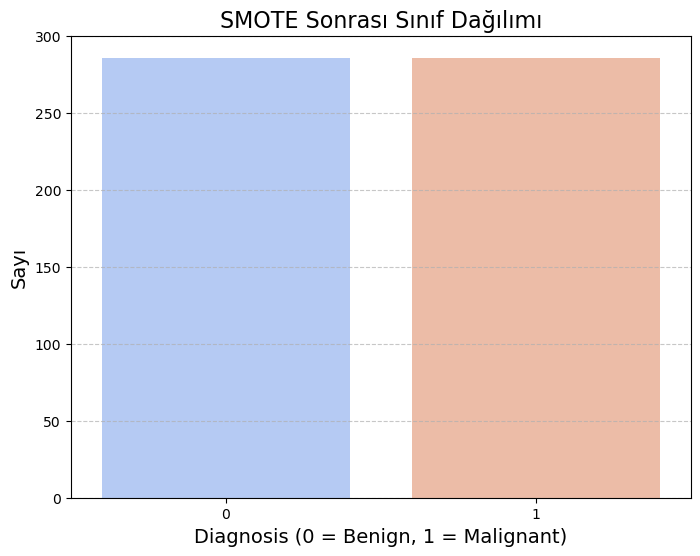

In [309]:


# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X_normalized_df, y, test_size=0.2, random_state=42)

# SMOTE ile dengeleme
if class_ratios.min() < 0.4:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # SMOTE sonrası sınıf dağılımını görselleştirme
    print("\n=== SMOTE Sonrası Sınıf Dağılımı ===")
    print(pd.Series(y_train_balanced).value_counts())

    plt.figure(figsize=(8, 6))
    sns.countplot(x=y_train_balanced,hue=y_train_balanced, palette="coolwarm", legend=False)
    plt.title("SMOTE Sonrası Sınıf Dağılımı", fontsize=16)
    plt.xlabel("Diagnosis (0 = Benign, 1 = Malignant)", fontsize=14)
    plt.ylabel("Sayı", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    X_train_balanced, y_train_balanced = X_train, y_train
    print("\nVeri dengeli olduğu için SMOTE uygulanmadı.")


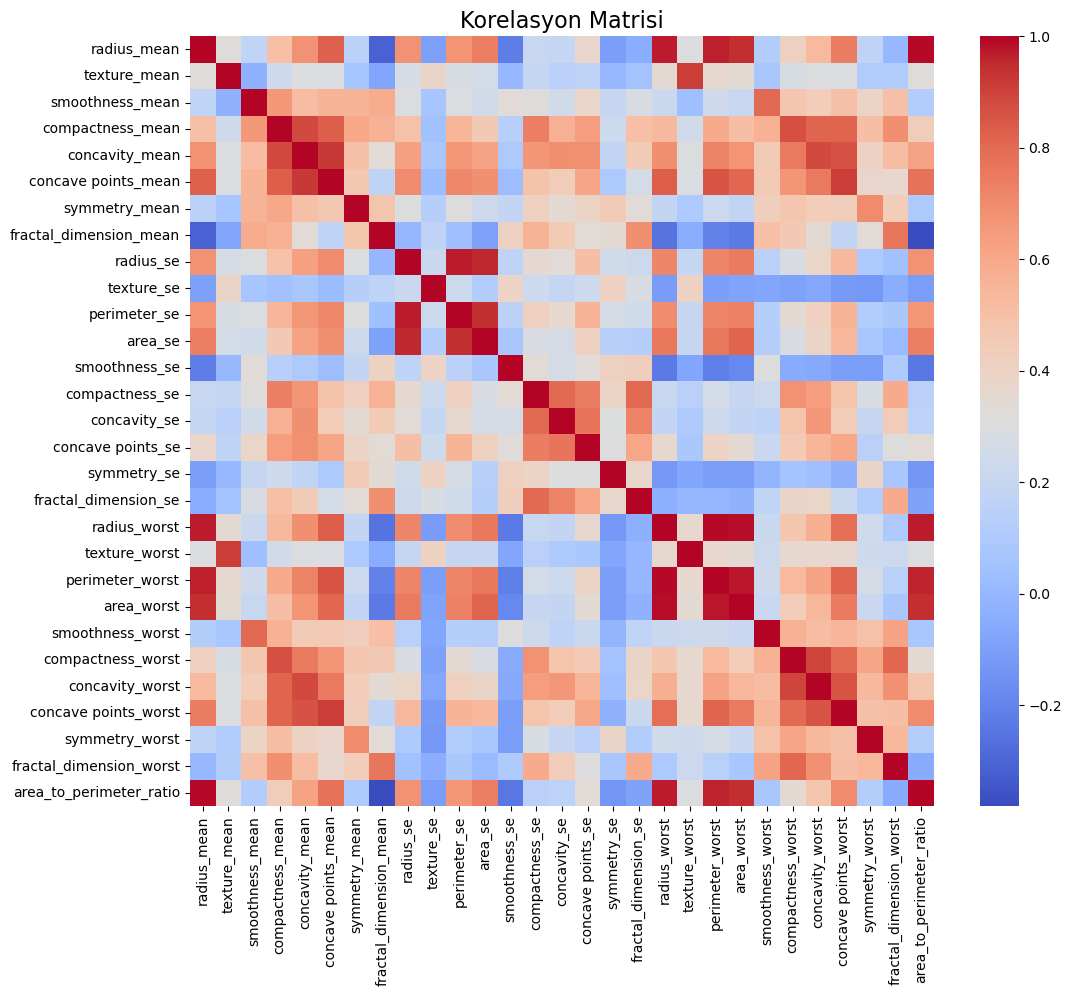

In [310]:
# Korelasyon matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = X_normalized_df.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
plt.title("Korelasyon Matrisi", fontsize=16)
plt.show()


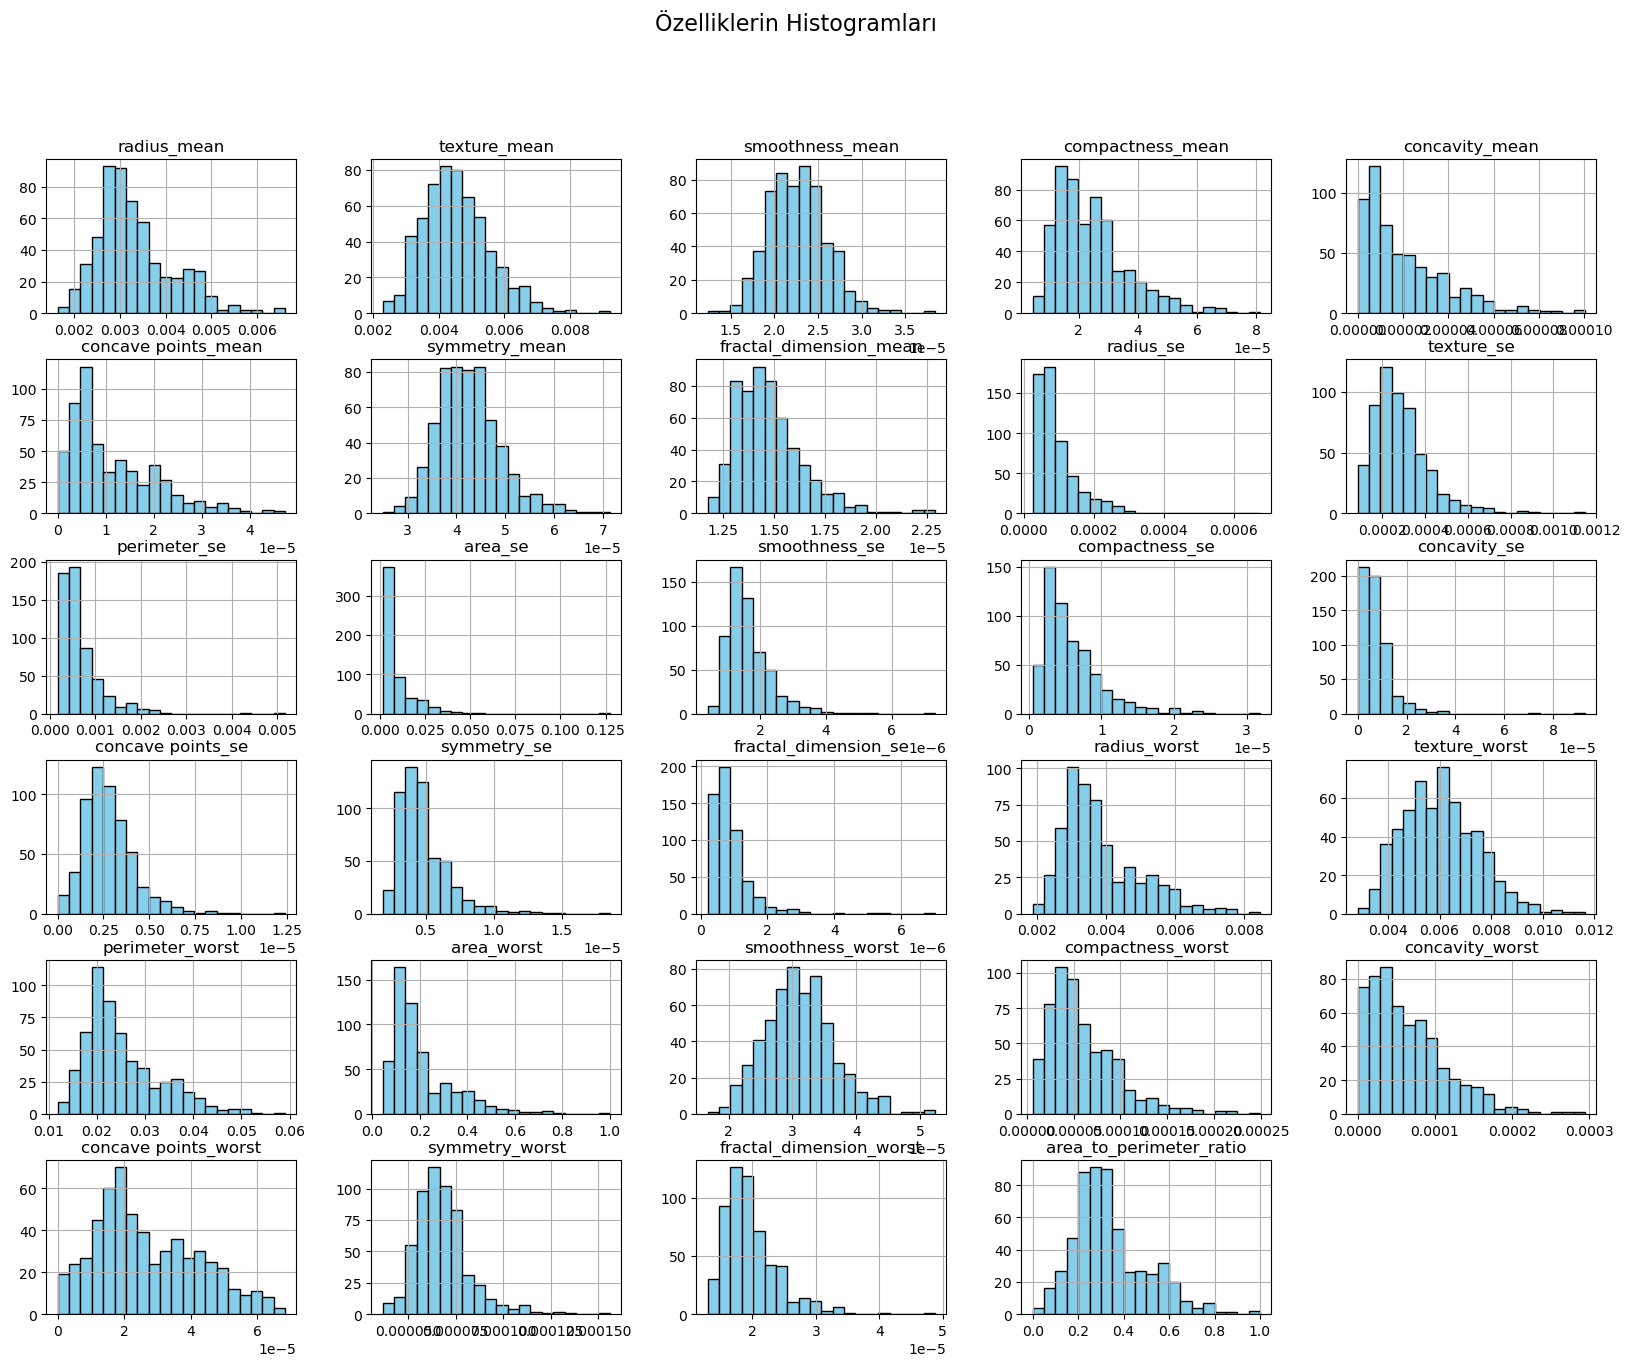

In [311]:
# Histogramlar
X_normalized_df.hist(bins=20, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Özelliklerin Histogramları', fontsize=16)
plt.show()


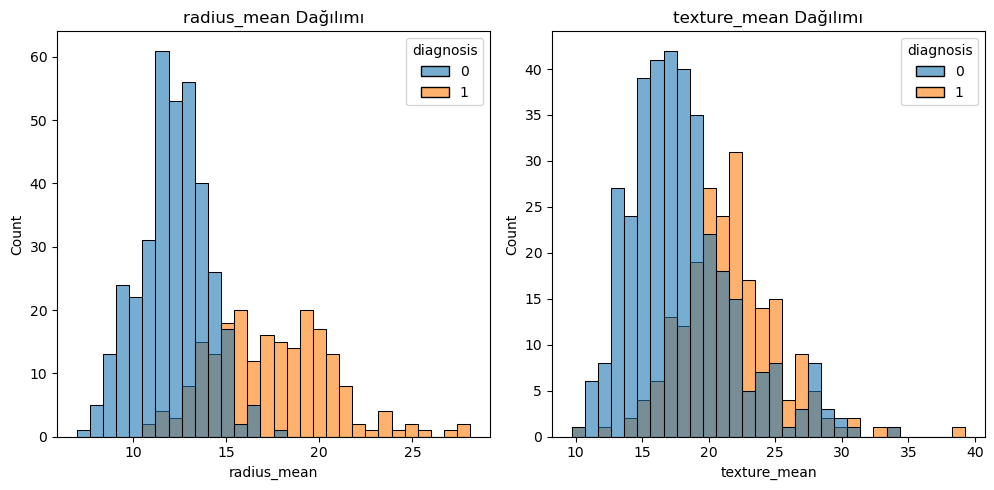

In [312]:
#  Önemli özelliklerin dağılımları
plt.figure(figsize=(15, 5))
for i, feature in enumerate(['radius_mean', 'texture_mean'][:2]):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=data, x=feature, hue='diagnosis', bins=30, multiple="layer", alpha=0.6)
    plt.title(f'{feature} Dağılımı')
plt.tight_layout()
plt.show()

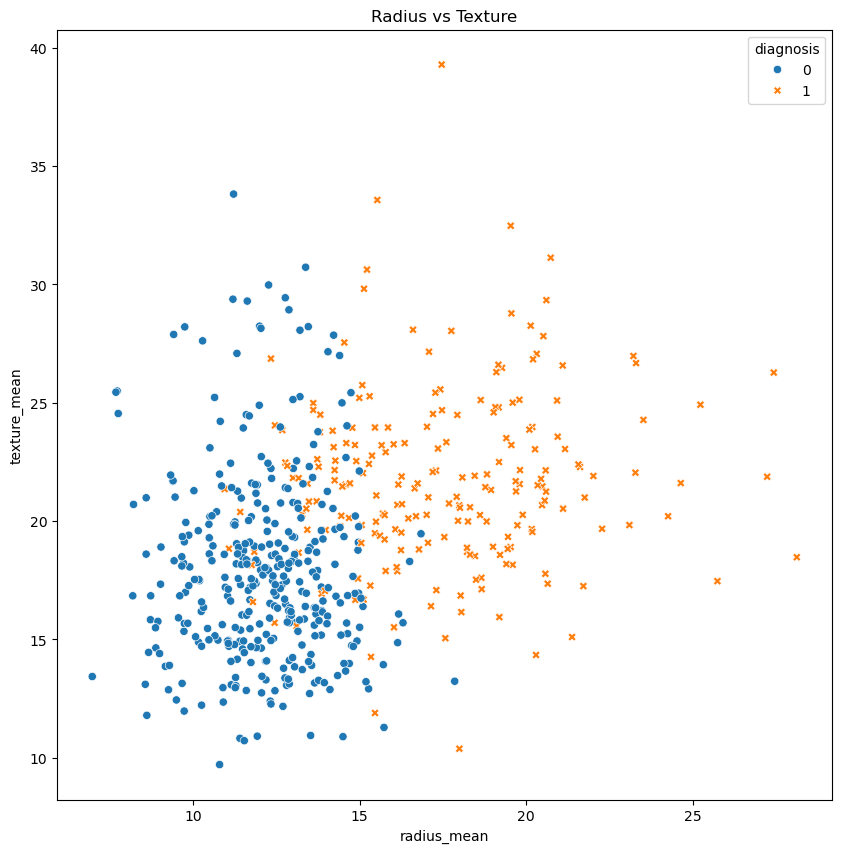

In [313]:
# İlk iki Özelliğin Scatter Plot Matrix
important_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='radius_mean', y='texture_mean', hue='diagnosis', style='diagnosis')
plt.title('Radius vs Texture')
plt.show()

## Makine Öğrenmesi Modelleri

Dört farklı model için hiperparametre aralıkları tanımlandı ve GridSearchCV kullanılarak bu parametreler optimize ediyoruz.Her modelin en iyi hiperparametre kombinasyonu bulundu. Buradaki amaç ise modellerin performansını artırmak ve veri setine en uygun parametrelerle çalışmasını sağlamak

In [406]:

# Modelleri tanımlama
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Hiperparametre aralıklarını tanımlama 
param_grid = {
    "DecisionTree": {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]},
    "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "LogisticRegression": {"C": [0.1, 1, 10]}
}
# Olabilecek en iyi hiperparametreler seçildi
best_models = {}
for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name], scoring='accuracy', cv=5, verbose=0)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")


Optimizing DecisionTree...
Best parameters for DecisionTree: {'max_depth': 5, 'min_samples_split': 10}
Best cross-validation accuracy for DecisionTree: 0.9385
Optimizing RandomForest...
Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 100}
Best cross-validation accuracy for RandomForest: 0.9582
Optimizing SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.9319
Optimizing LogisticRegression...
Best parameters for LogisticRegression: {'C': 10}
Best cross-validation accuracy for LogisticRegression: 0.8879


In [392]:
#overfitting kontrolü yapıldı
overfitting_results = []

for model_name, model in best_models.items():
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    overfitting_results.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Overfitting Risk": "High" if (train_accuracy - test_accuracy) > 0.1 else "Low"
    })

# Eğer bir modelde overfitting varsa düzenlemeler yap
for model_name, model in best_models.items():
    if model_name == "DecisionTree":
        model.set_params(max_depth=5, min_samples_split=10)
    elif model_name == "RandomForest":
        model.set_params(n_estimators=50, max_depth=5)
    elif model_name == "SVM":
        model.set_params(C=1)
    elif model_name == "LogisticRegression":
        model.set_params(C=0.1)
    model.fit(X_train, y_train)


In [394]:
print("=== Overfitting Analizi ===\n")
for result in overfitting_results:
    model_name = result["Model"]
    train_accuracy = result["Train Accuracy"]
    test_accuracy = result["Test Accuracy"]
    overfitting_risk = result["Overfitting Risk"]
    difference = train_accuracy - test_accuracy
    
    print(f"Model: {model_name}")
    print(f" - Train Accuracy: {train_accuracy:.4f}")
    print(f" - Test Accuracy: {test_accuracy:.4f}")
    print(f" - Accuracy Difference: {difference:.4f}")
    print(f" - Overfitting Risk: {overfitting_risk}\n")


=== Overfitting Analizi ===

Model: DecisionTree
 - Train Accuracy: 0.9868
 - Test Accuracy: 0.9474
 - Accuracy Difference: 0.0394
 - Overfitting Risk: Low

Model: RandomForest
 - Train Accuracy: 0.9934
 - Test Accuracy: 0.9649
 - Accuracy Difference: 0.0285
 - Overfitting Risk: Low

Model: SVM
 - Train Accuracy: 0.9033
 - Test Accuracy: 0.9386
 - Accuracy Difference: -0.0353
 - Overfitting Risk: Low

Model: LogisticRegression
 - Train Accuracy: 0.7846
 - Test Accuracy: 0.7544
 - Accuracy Difference: 0.0302
 - Overfitting Risk: Low



In [315]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

results = []
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    results.append({"Model": model_name, "Accuracy": accuracy, "ROC-AUC": roc_auc})



Evaluating DecisionTree...
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Accuracy: 0.9474
ROC-AUC: 0.9448

Evaluating RandomForest...
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 0.9649
ROC-AUC: 0.9959

Evaluating SVM...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        71
           1       1.00      0.93      0.96        43

    accuracy                           0.

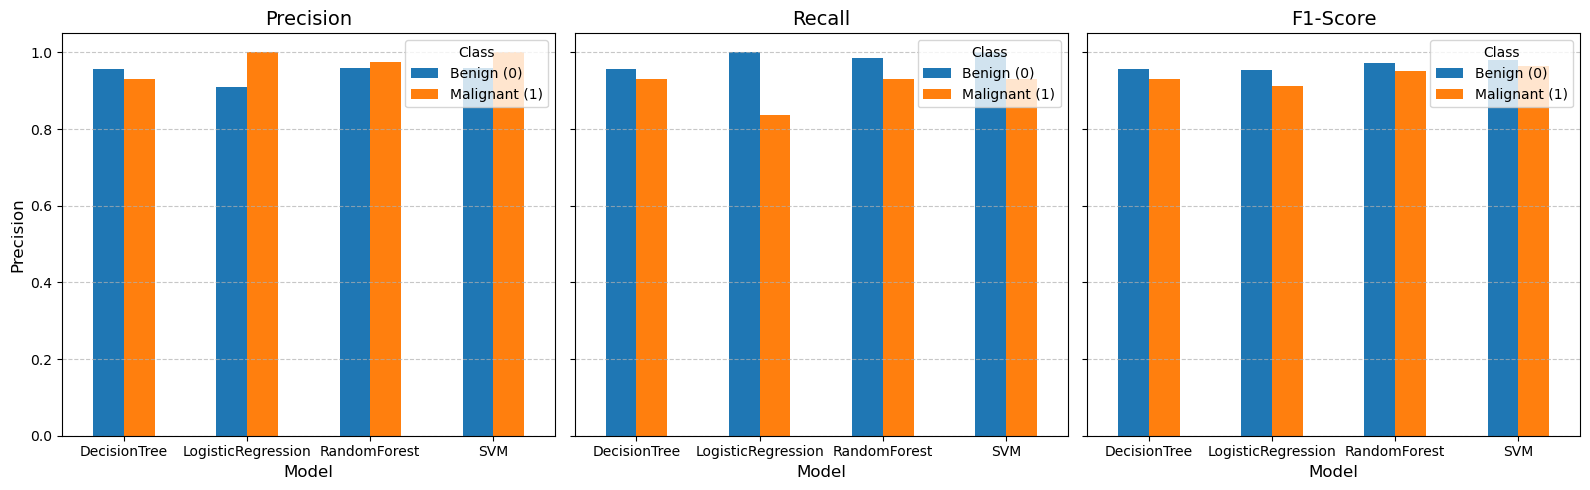

In [410]:
# Precision, Recall ve F1-Score grafiklerine göz atalım

# Grafikler için metrikler
metrics = ['Precision', 'Recall', 'F1-Score']

# Yan yana grafik alanı oluşturma
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Her bir metriği çizme
for i, metric in enumerate(metrics):
    pivot_table[metric].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{metric}", fontsize=14)
    axes[i].set_xlabel("Model", fontsize=12)
    if i == 0:  # Sadece ilk grafikte y eksenini ekle
        axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)  # X ekseni etiketlerini döndürmeden göster
    axes[i].legend(title="Class", labels=['Benign (0)', 'Malignant (1)'], loc='best')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Alanın düzenlenmesi
plt.tight_layout()
plt.show()

In [317]:
results_df = pd.DataFrame(results)
print(results_df)


                Model  Accuracy   ROC-AUC
0        DecisionTree  0.947368  0.944808
1        RandomForest  0.964912  0.995906
2                 SVM  0.973684  0.998035
3  LogisticRegression  0.938596  0.982968


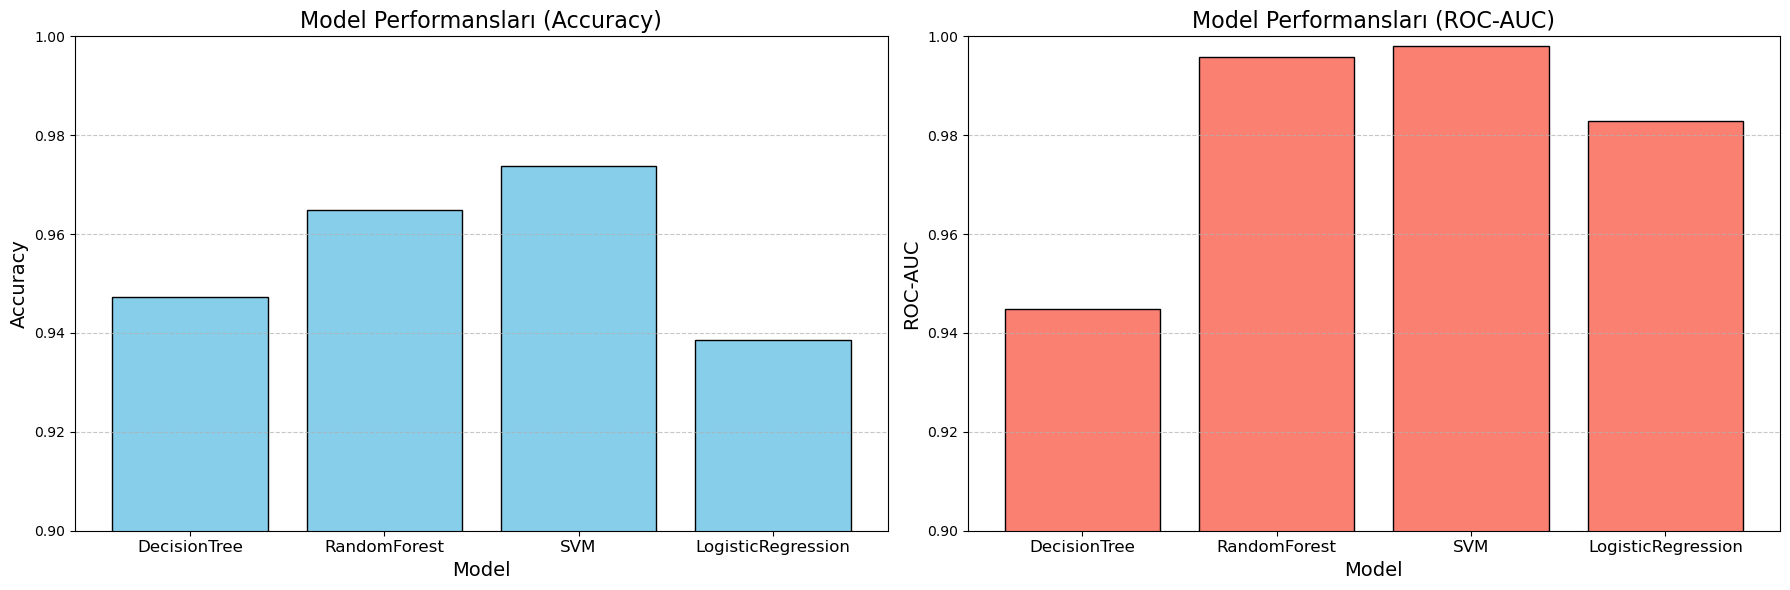

In [318]:
# Accuracy ve ROC-AUC grafiklerini
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Accuracy Grafiği
axes[0].bar(results_df['Model'], results_df['Accuracy'], color='skyblue', edgecolor='black')
axes[0].set_title('Model Performansları (Accuracy)', fontsize=16)
axes[0].set_xlabel('Model', fontsize=14)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_ylim(0.9, 1)  # Doğruluk oranlarını daha iyi vurgulamak için ölçeği daraltıyoruz
axes[0].tick_params(axis='x', labelsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. ROC-AUC Grafiği
axes[1].bar(results_df['Model'], results_df['ROC-AUC'], color='salmon', edgecolor='black')
axes[1].set_title('Model Performansları (ROC-AUC)', fontsize=16)
axes[1].set_xlabel('Model', fontsize=14)
axes[1].set_ylabel('ROC-AUC', fontsize=14)
axes[1].set_ylim(0.9, 1)  # ROC-AUC değerlerini daha iyi vurgulamak için ölçeği daraltıyoruz
axes[1].tick_params(axis='x', labelsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Model Performans Sonuçlarının Detaylı Analizi
### Logistic Regression
#### Avantajlar:
Hızlı ve Basit: Kanser teşhisi gibi zaman hassasiyeti gerektiren bir durumda hızlı sonuç verir.

Genelleme Yeteneği Yüksek: Eğitim ve test doğrulukları arasındaki fark çok düşük, bu da modelin farklı veri setlerinde iyi performans gösterebileceğini gösterir.

Yüksek Recall (%95): Pozitif sınıfları (kanserli hastaları) doğru bulma oranı yüksek, bu da yanlış negatiflerin az olduğu anlamına gelir.

Düşük Hesaplama Maliyeti: Klinik ortamda kullanılabilir, çünkü eğitim süreci kısa ve model hafif.

#### Dezavantajlar:

Doğrusal Model: Veri setinde doğrusal olmayan ilişkiler varsa performansı düşebilir.

Karmaşık Veriler için Sınırlı: Daha karmaşık veri setlerinde Random Forest veya SVM kadar güçlü olmayabilir.
_______________________________________________________________________________________________

## Random Forest

#### Avantajlar:

Genelleme Yeteneği: Gürültüye dayanıklı ve karmaşık verilerde yüksek performans gösterir.

Yüksek Doğruluk ve ROC-AUC: Bu proje için %97.37 doğruluk ve %99.40 ROC-AUC ile yüksek ayrım gücü sunar.

Overfitting Az: Ensembel yöntemi sayesinde overfitting riski düşüktür.

Özellik Önem Analizi: Hangi özelliklerin teşhiste daha etkili olduğunu analiz etmek için kullanılabilir.

#### Dezavantajlar:

Hesaplama Maliyeti: Klinik ortamlarda gerçek zamanlı kullanımı zor olabilir, çünkü eğitim süresi Logistic Regression’dan daha uzundur.

Yorumlanabilirlik: Birçok ağacın birleşiminden oluştuğu için modelin kararlarını anlamak zordur.

_______________________________________________________________________________________________
### SVM (Support Vector Machine)

#### Avantajlar:

Karmaşık Sınıflandırmalarda Güçlü: Kanser gibi karmaşık sınırlarla ayrılan veri setlerinde yüksek doğruluk sağlar.

Yüksek ROC-AUC (%99.44): Kanserli ve kanserli olmayan sınıfları ayırt etmede güçlü bir performans sunar.

Genel Performans Dengeli: %97.37 doğruluk ve %95 F1-Score ile hem yanlış pozitifleri hem de yanlış negatifleri kontrol altında tutar.

#### Dezavantajlar:

Hızlı Değil: Özellikle büyük veri setlerinde eğitim süresi Logistic Regression’a göre çok daha uzundur.

Kernel Seçimi Karmaşıklığı: Kernel seçimi kritik olduğu için uzmanlık gerektirir.

_______________________________________________________________________________________________
## Decision Tree

#### Avantajlar:

Basit ve Hızlı: Eğitim süresi çok kısa ve yorumlanabilir bir modeldir.

Yorumlanabilirlik: Karar yapısı açık olduğu için doktorların teşhis süreçlerinde hangi özelliklerin daha etkili olduğunu anlamalarını sağlar.

#### Dezavantajlar:

Overfitting Riski: Daha küçük ve basit veri setlerinde overfitting yapabilir.

Daha Düşük Performans: %93.86 doğruluk ve %94.25 ROC-AUC ile diğer modellere kıyasla daha düşük bir ayrım yeteneği sunar.

### SONUÇ :
Bu proje özelinde SVM, teşhis sürecinde en iyi performansı sergileyen model oldu. Doğruluğu yüksek, hızlı ve genelleme yeteneği oldukça iyi. Yanlış negatiflerin ve pozitiflerin dengeli şekilde azaltılması gerektiği için bu model teşhis sürecinde güvenle kullanılabilir.

# Öneriler

Deep Learning gibi daha karmaşık modellerin uygulanması performansı artırabilir.

Daha fazla veri toplanarak modelin genel performansı artırılabilir.

Veri kaynakları, kullanılan metriklerin detaylı analizi ve iş hedefleriyle uyumu açıklanabilir. Bu, modelin iş değerini artıracaktır.
